# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
PATH = "data/demand-forecasting/"

# Helper Functions

In [5]:
# custom evaluation metric
def SMAPE(y_pred, dtrain):
    y_true = dtrain.get_label()
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 'SMAPE', np.nanmean(diff)

In [6]:
def smape2(y_pred, y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [7]:
def print_scores(pred,label):
    rmse = np.sqrt(mean_squared_error(pred,label))
    mae = mean_absolute_error(pred,label)
    smape_score = smape2(pred,label)
    
    print('RMSE: ' + str(rmse))
    print('MAE: ' + str(mae))
    print('SMAPE: ' + str(smape_score))

In [8]:
def plot_learning_curve(results,trn,val,metric):
    train_errors = results[trn][metric]
    validation_errors = results[val][metric]
    df = pd.DataFrame([train_errors, validation_errors]).T
    df.columns = ['Training', 'Validation']
    df.index.name = 'Boosting Round'
    ax = df.plot(title="XGBoost learning curves",figsize=(12,5))
    ax.set_ylabel(metric)

# Pre-Process Data

In [9]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'], index_col='id')

In [10]:
train['y'] = train['date'].dt.year
train['m'] = train['date'].dt.month
train['d'] = train['date'].dt.day
train['dw'] = train['date'].dt.dayofweek
train['dy'] = train['date'].dt.dayofyear
train.drop('date', axis=1, inplace=True)

sales = train.pop('sales')

In [11]:
test['y'] = test['date'].dt.year
test['m'] = test['date'].dt.month
test['d'] = test['date'].dt.day
test['dw'] = test['date'].dt.dayofweek
test['dy'] = test['date'].dt.dayofyear
test.drop('date', axis=1, inplace=True)

# Split Training-Validation Data

In [12]:
train.shape, sales.shape, test.shape

((913000, 7), (913000,), (45000, 7))

In [13]:
# closest same period (diff year) as test set
X_val = train.loc[(train.y==2017) & ((train.m==10) | (train.m==11) | (train.m==12))].copy() 
y_val = sales[X_val.index].copy()

X_train = train.drop(X_val.index).copy()
y_train = sales.drop(X_val.index).copy()

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((867000, 7), (867000,), (46000, 7), (46000,))

In [15]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
print()

# XGBoost API

In [16]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_val = xgb.DMatrix(data=X_val, label=y_val)
DM_test = xgb.DMatrix(data=test)

In [17]:
evals_result = {}
watchtlist_trn = "training"
watchtlist_val = "validation"
watchlist = [(DM_train, watchtlist_trn), (DM_val, watchtlist_val)]

In [18]:
params_native = {
    'objective': 'reg:linear',  # 'reg:linear'
    'booster':'gbtree',         # 'gbtree'
    'silent': 1,                # 0   
    'eta': 0.05,                # 0.3 (alias learning_rate)
    'gamma': 0,                 # 0
    'max-depth': 7,             # 6
    'min_child_weight': 1,      # 1
    'max_delta_step': 0,        # 0
    'subsample': 0.7,           # 1
    'colsample_bytree': 0.7,    # 1
    'colsample_bylevel': 1,     # 1
    'lambda': 1,                # 1  
    'alpha': 0,                 # 0
    'scale_pos_weight': 1,      # 1
    'base_score': 0.5,          # 0.5
    'eval_metric':'rmse',       # 'rmse' for regression
    'seed': 42                  # 0 
}

In [19]:
%%time
xgb_native = xgb.train(params=params_native, 
                            dtrain=DM_train,
                            num_boost_round=10001,
                            evals=watchlist,
#                             feval=SMAPE,
#                             maximize=False,
                            early_stopping_rounds=10,
                            evals_result=evals_result,
                            verbose_eval=100)

[0]	training-rmse:56.6901	validation-rmse:58.9562
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[100]	training-rmse:13.0062	validation-rmse:13.7344
[200]	training-rmse:9.35989	validation-rmse:9.80527
[300]	training-rmse:8.45606	validation-rmse:8.77657
[400]	training-rmse:8.13617	validation-rmse:8.45338
[500]	training-rmse:7.96341	validation-rmse:8.27719
[600]	training-rmse:7.80921	validation-rmse:8.14128
[700]	training-rmse:7.66969	validation-rmse:8.01661
[800]	training-rmse:7.58012	validation-rmse:7.94818
[900]	training-rmse:7.4905	validation-rmse:7.86991
[1000]	training-rmse:7.42637	validation-rmse:7.81057
[1100]	training-rmse:7.38709	validation-rmse:7.77678
[1200]	training-rmse:7.35783	validation-rmse:7.75137
[1300]	training-rmse:7.33351	validation-rmse:7.73284
Stopping. Best iteration:
[1319]	training-rmse:7.32692	validation-rmse:7.72491

Wall time: 6min 9s


In [20]:
print("Best iteration: {}".format(xgb_native.best_iteration))
print("Best number of trees limit: {}".format(xgb_native.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_native.best_score))

Best iteration: 1319
Best number of trees limit: 1320
Best RMSE score: 7.724912


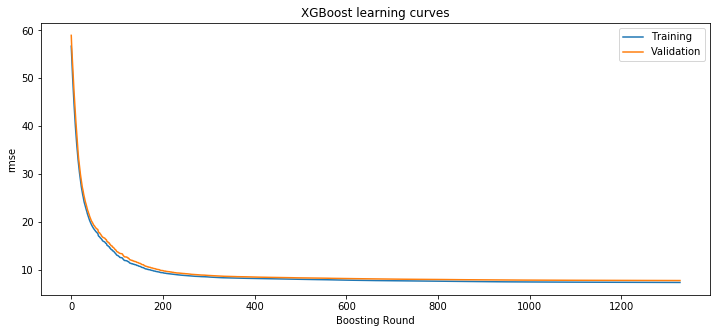

In [22]:
plot_learning_curve(evals_result, watchtlist_trn, watchtlist_val, 'rmse')

# Scikit Learn API

In [23]:
params_sklearn = {
    'objective': 'reg:linear',  # 'reg:linear'
    'booster':'gbtree',         # 'gbtree'
    'silent': True,             # True
    'max-depth': 7,             # 3
    'learning_rate': 0.05,      # 0.1
    'n_estimators': 10001,      # 200
    'n_jobs': 4,                # 1 (replaces nthread)
    'gamma': 0,                 # 0
    'min_child_weight': 1,      # 1
    'max_delta_step': 0,        # 0
    'subsample': 0.7,           # 1
    'colsample_bytree': 0.7,    # 1
    'colsample_bylevel': 1,     # 1
    'reg_alpha': 0,             # 0
    'reg_lambda': 1,            # 1
    'scale_pos_weight': 1,      # 1
    'base_score': 0.5,          # 0.5
    'random_state': 42,         # 0 (seed is deprecated) 
}

In [24]:
xgb_sk = xgb.XGBRegressor(**params_sklearn)

In [25]:
%%time
xgb_sk = xgb_sk.fit(X_train, y_train,  
                              eval_set=[(X_train, y_train),(X_val, y_val)],
                              eval_metric='rmse',
                              verbose=50,
                              early_stopping_rounds=10)          

[0]	validation_0-rmse:56.7836	validation_1-rmse:59.0074
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[50]	validation_0-rmse:22.7172	validation_1-rmse:23.2888
[100]	validation_0-rmse:19.4848	validation_1-rmse:20.0782
[150]	validation_0-rmse:17.4077	validation_1-rmse:18.0555
[200]	validation_0-rmse:15.4587	validation_1-rmse:16.068
[250]	validation_0-rmse:14.2125	validation_1-rmse:14.7551
[300]	validation_0-rmse:13.1134	validation_1-rmse:13.5944
[350]	validation_0-rmse:12.0242	validation_1-rmse:12.4276
[400]	validation_0-rmse:11.32	validation_1-rmse:11.6559
[450]	validation_0-rmse:10.9523	validation_1-rmse:11.2448
[500]	validation_0-rmse:10.6874	validation_1-rmse:10.9398
[550]	validation_0-rmse:10.4506	validation_1-rmse:10.678
[600]	validation_0-rmse:10.2478	validation_1-rmse:10.44
[650]	validation_0-rmse:10.0736	validation_1-rmse:10.2376
[700]	validation_0-rmse:9.91069	valida

In [26]:
print("Best iteration: {}".format(xgb_sk.best_iteration))
print("Best number of trees limit: {}".format(xgb_sk.best_ntree_limit))
print("Best SMAPE score: {}".format(xgb_sk.best_score))

Best iteration: 2576
Best number of trees limit: 2577
Best SMAPE score: 8.845988


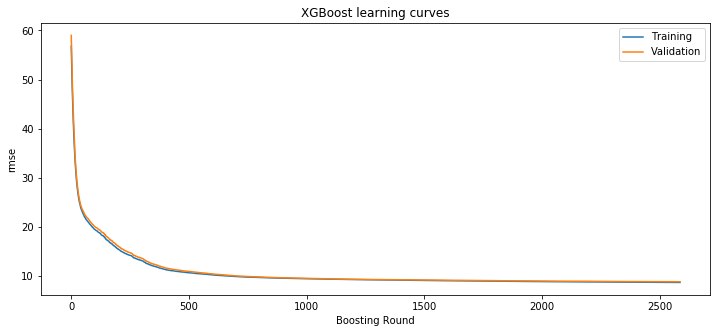

In [27]:
plot_learning_curve(xgb_sk.evals_result(), 'validation_0', 'validation_1', 'rmse')

# Comparisons

In [28]:
print("Native")
print("Best iteration: {}".format(xgb_native.best_iteration))
print("Best number of trees limit: {}".format(xgb_native.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_native.best_score))

print("\nSKLearn")
print("Best iteration: {}".format(xgb_sk.best_iteration))
print("Best number of trees limit: {}".format(xgb_sk.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_sk.best_score))

Native
Best iteration: 1319
Best number of trees limit: 1320
Best RMSE score: 7.724912

SKLearn
Best iteration: 2576
Best number of trees limit: 2577
Best RMSE score: 8.845988


In [29]:
print("Training score Native")
pred_train = xgb_native.predict(DM_train)
print_scores(pred_train, y_train)

print("\nTraining score SKLearn")
pred_train = xgb_sk.predict(X_train)
print_scores(pred_train, y_train)

Training score Native
RMSE: 7.325840654118261
MAE: 5.638051134403739
SMAPE: 12.747186047753106

Training score SKLearn
RMSE: 8.704655108209987
MAE: 6.723292998952781
SMAPE: 17.01076157476725


In [30]:
print("Validation score Native")
pred_val = xgb_native.predict(DM_val)
print_scores(pred_val, y_val)

print("\nValidation score SKLearn")
pred_val = xgb_sk.predict(X_val)
print_scores(pred_val, y_val)

Validation score Native
RMSE: 7.724964527848548
MAE: 5.969841442730115
SMAPE: 12.600440639639533

Validation score SKLearn
RMSE: 8.846404878518847
MAE: 6.876873116042303
SMAPE: 15.731236236343525


# Predict with partially-trained xgb_native

In [31]:
y_pred = xgb_native.predict(DM_test, ntree_limit = xgb_native.best_ntree_limit)

# Predict with fully-trained xgb_native

In [42]:
%%time
full_data = xgb.DMatrix(data=train, label=sales)
xgb_native_full_data = xgb.train(params=params_native, 
                                dtrain=full_data,
                                num_boost_round=1501,
                                evals=[(full_data, "training")],
                                verbose_eval=100)

[0]	training-rmse:56.7417
[100]	training-rmse:13.018
[200]	training-rmse:9.53568
[300]	training-rmse:8.56749
[400]	training-rmse:8.15204
[500]	training-rmse:7.92449
[600]	training-rmse:7.74787
[700]	training-rmse:7.63164
[800]	training-rmse:7.54901
[900]	training-rmse:7.46579
[1000]	training-rmse:7.41809
[1100]	training-rmse:7.38758
[1200]	training-rmse:7.36102
[1300]	training-rmse:7.34323
[1400]	training-rmse:7.32358
[1500]	training-rmse:7.30607
Wall time: 6min 1s


In [43]:
y_pred = xgb_native_full_data.predict(DM_test)

# Submission

In [44]:
submission = pd.read_csv(f'{PATH}test.csv', index_col='id')

In [45]:
submission['sales'] = y_pred

In [46]:
csv_fn = f'{PATH}tmp/XGB_v2_full.csv'

In [47]:
submission[['sales']].to_csv(csv_fn)

__KAGGLE SCORE: __
- 14.27247 (with val)
- 14.25877 (full with 1500 boost)